In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from dataloader_multiclass import load_mnist

# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def build_rnn_model(seq_len=4, n_classes=10):
    """
    Builds a simple LSTM-based RNN for classification.
    Args:
        seq_len: Number of features from CNN (sequence length)
        n_classes: Number of output classes (10 for MNIST)
    Returns:
        Keras model
    """
    inputs = layers.Input(shape=(seq_len, 1))  # Reshape features as (seq_len, 1)
    x = layers.LSTM(64, return_sequences=False)(inputs)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_rnn(n_train, n_test, n_epochs=100, seq_len=4, batch_size=16):
    """
    Trains an RNN on CNN-extracted MNIST features.
    Args:
        n_train: Number of training samples
        n_test: Number of test samples
        n_epochs: Number of training epochs
        seq_len: Sequence length (CNN feature dimension)
        batch_size: Batch size for training
    Returns:
        history: Training history (loss, accuracy)
    """
    # Load data from dataloader_multiclass.py
    x_train, y_train, x_test, y_test = load_mnist(n_train, n_test, seq_len, train_cnn_epochs=None, force_retrain=False)
    
    # Reshape for RNN: (n_samples, seq_len, 1)
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)

    # Build and train RNN
    model = build_rnn_model(seq_len=seq_len, n_classes=y_train.shape[1])
    history = model.fit(x_train, y_train, epochs=n_epochs, batch_size=batch_size,
                       validation_data=(x_test, y_test), verbose=1)

    # Plot training history
    epochs = list(range(1, n_epochs + 1))
    plt.figure(figsize=(10, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('rnn_classical_plot.png')
    plt.close()

    return history

if __name__ == '__main__':
    history = train_rnn(n_train=1000, n_test=200, n_epochs=100, seq_len=4, batch_size=16)
    print('Max Test Acc:', max(history.history['val_accuracy']))

ValueError: Argument `cell` should have a `call` method. Received: cell=64

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import keras
import torch
import jax

In [2]:
import jax.numpy as jnp
from sklearn.decomposition import PCA

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train, y_train = X_train[(y_train == 0) | (y_train == 1)], y_train[(y_train == 0) | (y_train == 1)]
X_test, y_test = X_test[(y_test == 0) | (y_test == 1)], y_test[(y_test == 0) | (y_test == 1)]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


pca = PCA(n_components=16)
pca = pca.fit(X_train.reshape(-1, 28*28))
X_train_pca = pca.transform(X_train.reshape(-1, 28*28))
X_test_pca = pca.transform(X_test.reshape(-1, 28*28))
print(X_train_pca.shape)
print(X_test_pca.shape)





(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
(12665, 28, 28)
(12665,)
(2115, 28, 28)
(2115,)
(12665, 16)
(2115, 16)


In [17]:
from jax.nn import one_hot

In [20]:
def load_mnist(n_train = 15000, type = 'multiclass'):
    def patchify_images(images, patch_size=7):
        H, W = images.shape[1:]  # assume (N, 28, 28)
        patch_rows = H // patch_size
        patch_cols = W // patch_size
        sequences = []

        for img in images:
            seq = []
            for i in range(0, H, patch_size): # 0 to 28, 7 steps
                for j in range(0, W, patch_size): # 0 to 28, 7 steps
                    patch = img[i:i+patch_size, j:j+patch_size]
                    seq.append(np.mean(patch))  # or max, std, etc.
            sequences.append(seq)

        return np.array(sequences)

    def normalize_sequence(seq, min_val=0.0, max_val=255.0):
        return (seq - min_val) / (max_val - min_val) * np.pi
    
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    if type == 'binary':
        X_train, y_train = X_train[(y_train == 0) | (y_train == 1)], y_train[(y_train == 0) | (y_train == 1)]
        X_test, y_test = X_test[(y_test == 0) | (y_test == 1)], y_test[(y_test == 0) | (y_test == 1)]
        num_classes = 2 
    elif type == 'multiclass':
        X_train, y_train = X_train, y_train
        X_test, y_test = X_test, y_test
        num_classes = 10
    else:
        raise ValueError("Invalid type")

    train_indices = np.random.choice(len(X_train), size=n_train, replace=False)
    X_train_sampled = X_train[train_indices]
    y_train_sampled = y_train[train_indices]

    # Randomly sample 100 indices from testing set
    test_indices = np.random.choice(len(X_test), size=100, replace=False)
    X_test_sampled = X_test[test_indices]
    y_test_sampled = y_test[test_indices]
    X_train_seq = jnp.array(normalize_sequence(patchify_images(X_train_sampled)), dtype=jnp.float32)
    X_test_seq = jnp.array(normalize_sequence(patchify_images(X_test_sampled)), dtype=jnp.float32)
    y_train_bin = jnp.array(y_train_sampled.reshape(-1, 1), dtype=jnp.float32)
    y_test_bin = jnp.array(y_test_sampled.reshape(-1, 1), dtype=jnp.float32)
    y_train_bin = one_hot(y_train_bin.astype(int).flatten(), num_classes=num_classes)
    y_test_bin = one_hot(y_test_bin.astype(int).flatten(), num_classes=num_classes)
    return (
        X_train_seq,
        y_train_bin,
        X_test_seq,
        y_test_bin
    )




X_train_seq, y_train_bin, X_test_seq, y_test_bin = load_mnist(80)
print(X_train_seq.shape)
print(X_test_seq.shape)
print(y_train_bin.shape)
print(y_test_bin.shape)
print(X_train_seq[0])
print(X_test_seq[0])
print(y_train_bin[0])
print(y_test_bin[0])




(80, 16)
(100, 16)
(80, 10)
(100, 10)
[0.02690279 0.89080936 0.08347409 0.         0.         1.2020772
 1.8839499  0.03394278 0.         0.50009024 0.4807303  0.7014841
 0.         0.8794951  0.7195869  0.17373674]
[0.         0.0125714  0.907655   0.         0.         1.1336888
 0.51341593 0.         0.01407997 1.7087046  1.8583043  0.22452518
 0.01684568 0.42466187 0.46111894 0.        ]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [5]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
n_train, n_test = 80, 100
digits = load_digits()
X, y = digits.data, digits.target
mask = (y == 0) | (y == 1)
X, y = X[np.where((y == 0) | (y == 1))], y[np.where((y == 0) | (y == 1))]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)
X_train, y_train = X_train[:n_train], y_train[:n_train]
X_test, y_test = X_test[:n_test], y_test[:n_test]

In [6]:
print(jax.devices())

[CpuDevice(id=0)]


In [7]:
def load_cifar2(n_train = 100, n_test = 150, patch_size = 8, reduce_fn = np.mean):
    def rgb2gray(images):
    # Uses ITU-R BT.601 luma transform
        return 0.2989 * images[..., 0] + 0.5870 * images[..., 1] + 0.1140 * images[..., 2]
    def patchify_images(images):
        H, W = images.shape[1:]
        sequences = []
        for img in images:
            seq = [
                reduce_fn(img[i:i+patch_size, j:j+patch_size])
                for i in range(0, H, patch_size)
                for j in range(0, W, patch_size)
            ]
            sequences.append(seq)
        return np.array(sequences)

    def normalize_sequence(seq, min_val=0.0, max_val=255.0):
        return (seq - min_val) / (max_val - min_val) * np.pi
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

    y_train = y_train.squeeze() # (N, 1) -> (N,)
    y_test = y_test.squeeze() # (N, 1) -> (N,)

    train_mask = (y_train == 0) | (y_train == 1)
    test_mask = (y_test == 0) | (y_test == 1)
    np.random.seed(42)
    train_indices = np.random.choice(len(x_train[train_mask]), size=n_train, replace=False)
    test_indices = np.random.choice(len(x_test[test_mask]), size=n_test, replace=False)

    x_train_filtered = x_train[train_mask][train_indices]
    y_train_filtered = y_train[train_mask][train_indices]
    x_test_filtered = x_test[test_mask][test_indices]
    y_test_filtered = y_test[test_mask][test_indices]
    

    y_train_filtered = y_train_filtered.reshape(-1, 1)
    y_test_filtered = y_test_filtered.reshape(-1, 1)

    X_train_gray = rgb2gray(x_train_filtered)
    X_test_gray = rgb2gray(x_test_filtered)
    
    X_train_seq = jnp.array(normalize_sequence(patchify_images(X_train_gray)), dtype=jnp.float32)
    X_test_seq = jnp.array(normalize_sequence(patchify_images(X_test_gray)), dtype=jnp.float32)
    y_train_bin = jnp.array(y_train_filtered, dtype=jnp.float32)
    y_test_bin = jnp.array(y_test_filtered, dtype=jnp.float32)

    return X_train_seq, y_train_bin, X_test_seq, y_test_bin

X_train_seq, y_train_bin, X_test_seq, y_test_bin = load_cifar2()
print(X_train_seq.shape)
print(X_test_seq.shape)
print(y_train_bin.shape)
print(y_test_bin.shape)
print(X_train_seq[0])
print(X_test_seq[0])
print(y_train_bin[0])
print(y_test_bin[0])



(100, 16)
(150, 16)
(100, 1)
(150, 1)
[1.4535058  1.4176005  1.2892096  0.74873996 1.4132792  1.3925828
 1.8925732  1.6374066  1.6438335  2.0711334  1.8453851  2.0083055
 1.2324556  0.9225628  1.0374277  1.2239964 ]
[1.2327421  0.76124674 0.9099139  1.1127236  1.2969828  1.3933271
 1.2670116  0.9271903  1.6197511  1.666985   1.0040563  1.6477369
 0.93780416 0.57085615 1.342579   1.7252606 ]
[1.]
[1.]


In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

y_train = y_train.squeeze()
y_test = y_test.squeeze()

# Boolean masks
train_mask = (y_train == 0) | (y_train == 1)
test_mask = (y_test == 0) | (y_test == 1)
np.random.seed(2025)
n_train = 100
n_test = 100
train_indices = np.random.choice(len(x_train[train_mask]), size=n_train, replace=False)
test_indices = np.random.choice(len(x_test[test_mask]), size=n_test, replace=False)
# Apply boolean indexing
x_train_filtered = x_train[train_mask][train_indices]
y_train_filtered = y_train[train_mask][train_indices]
x_test_filtered = x_test[test_mask][test_indices]
y_test_filtered = y_test[test_mask][test_indices]

# Optional: reshape y back to (N, 1)
y_train_filtered = y_train_filtered.reshape(-1, 1)
y_test_filtered = y_test_filtered.reshape(-1, 1)

In [9]:
x_train_filtered.shape

(100, 32, 32, 3)

In [10]:
y_train_filtered.shape

(100, 1)

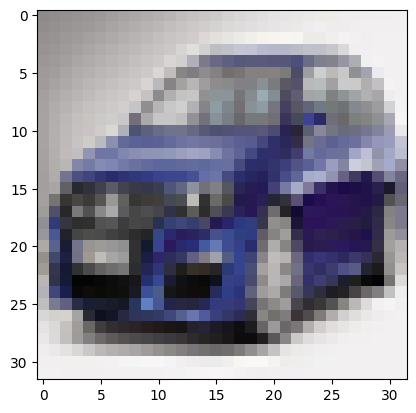

The label is:  [1]


In [11]:
plt.imshow(x_train_filtered[1])
plt.show()
print('The label is: ', y_train_filtered[1])

In [12]:
import cv2
import pandas as pd

In [1]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



NameError: name 'x_train' is not defined